In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.model_selection import cross_val_score
from scipy.stats import boxcox

import shap
import optuna
import warnings
warnings.filterwarnings('ignore')

In [33]:
def conf_matrix(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    mat = confusion_matrix(y_true, y_pred)
    labels = ['0(Non Risk)', '1(Risk)']
    colors=['whitesmoke', 'steelblue']
    sns.heatmap(mat, annot=True, cmap=colors, xticklabels=labels, yticklabels=labels, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    print('Accuracy:', acc)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1:', f1)

In [34]:
# 하이퍼 파라미터 튜닝 관련 함수 

def nav_objective(trial):

    param = {"var_smoothing" : trial.suggest_loguniform('var_smoothing', 1e-12, 1e-8)}
    model = GaussianNB(**param)
    
    # 교차 검증을 통한 성능 측정 (예시)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    return mean_score

def lg_objective(trial):
 
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'C': trial.suggest_loguniform("C", 1e-2, 1),
        'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
    }
    
    model = LogisticRegression(random_state=42, **params)
    scores = cross_val_score(model, X_train.values, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    return mean_score

def svm_objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.01, 10.0),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'coef0': trial.suggest_uniform('coef0', -1.0, 1.0),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }

    model = svm.SVC(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    return mean_score

In [4]:
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
df.columns = df.columns.str.replace(' ', '')
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

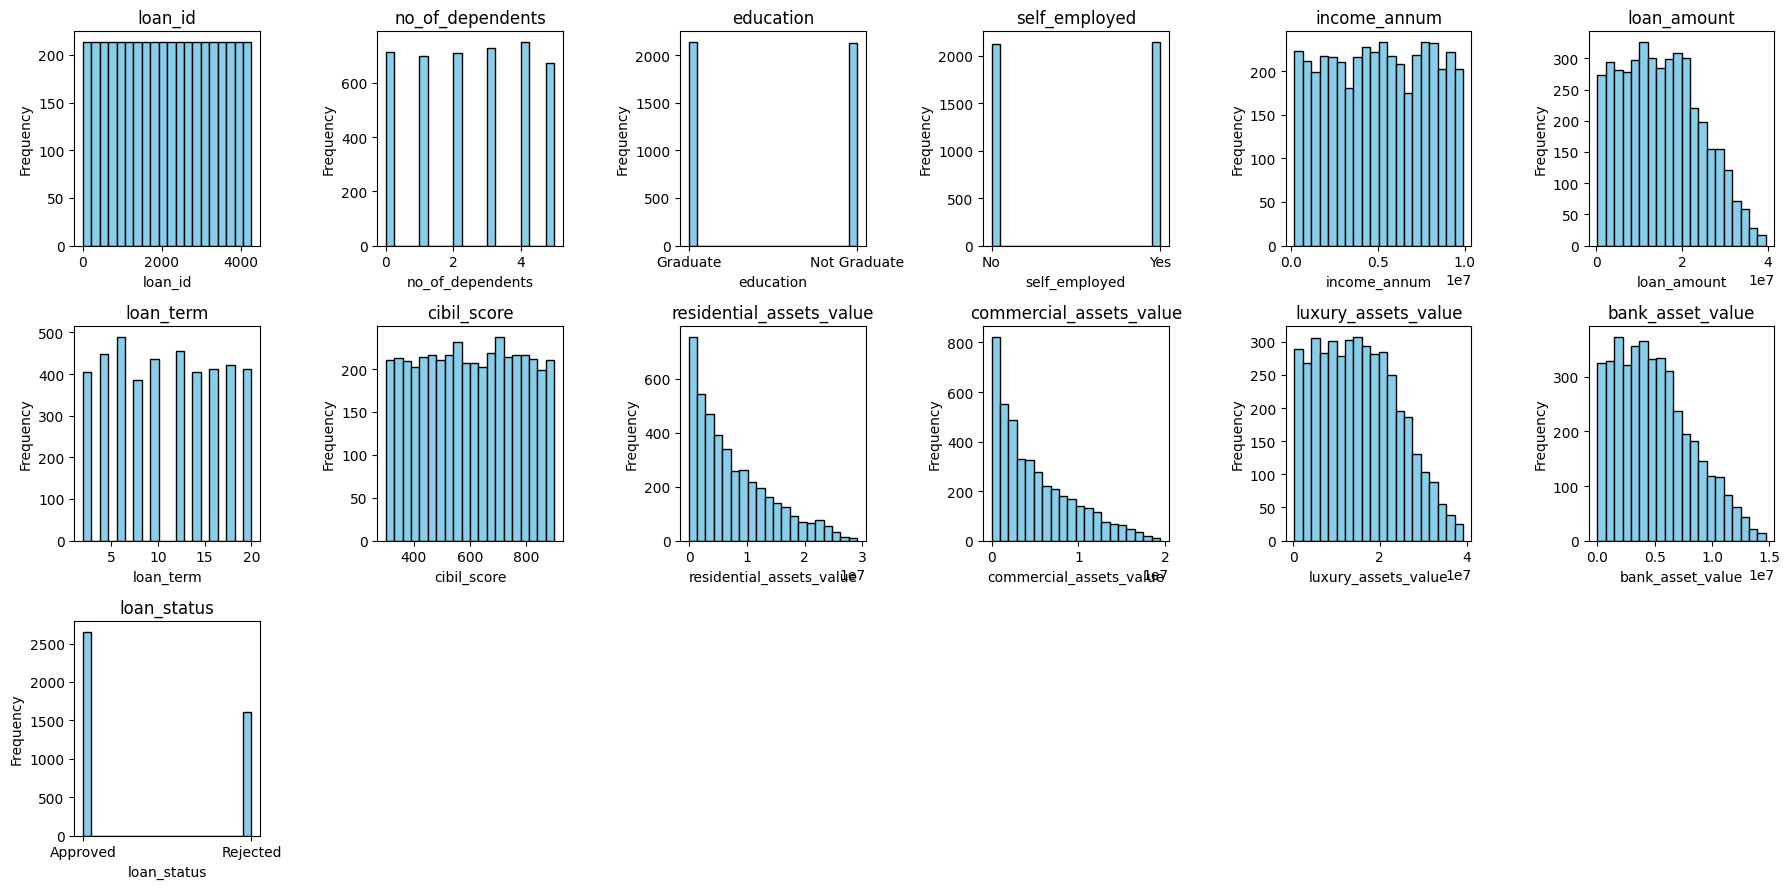

In [6]:
num_columns = len(df.columns)
num_rows = num_columns // 6 + 1

plt.figure(figsize=(18, num_rows * 3))

# 각 변수에 대한 히스토그램
for i, var in enumerate(df.columns):
    plt.subplot(num_rows, 6, i + 1)  # 서브플롯의 위치를 조정합니다.
    plt.hist(df[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# 로그 변환

df_log = df.copy()

df_log['log_residential'] = np.log1p(df['residential_assets_value'])
df_log['log_commercial'] = np.log1p(df['commercial_assets_value'])
df_log['log_luxury'] = np.log1p(df['luxury_assets_value'])
df_log['log_bank'] = np.log1p(df['bank_asset_value'])

df_log.drop(['loan_id','residential_assets_value','commercial_assets_value','luxury_assets_value','bank_asset_value' ] ,axis = 1, inplace = True)

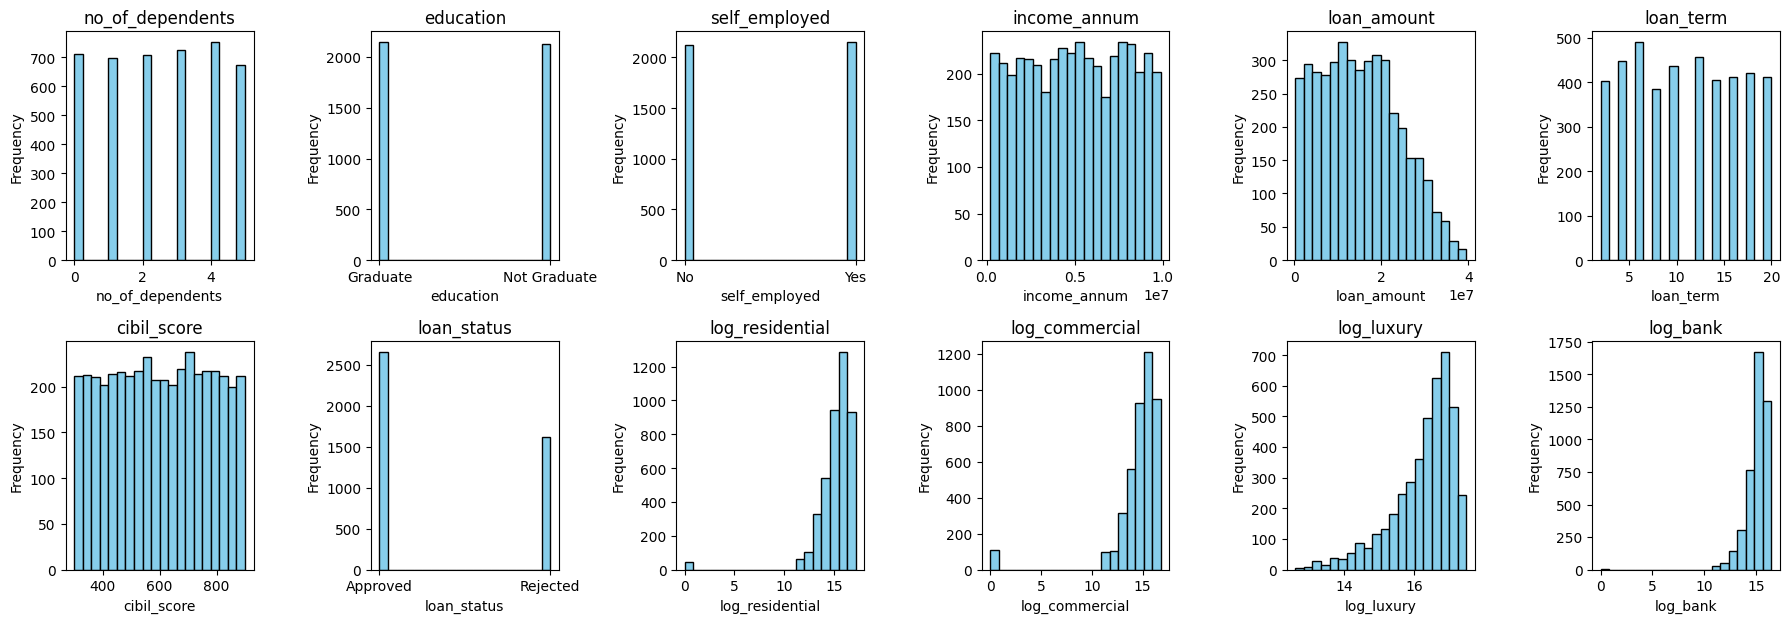

In [8]:
# 로그 변환 결과 오른쪽으로 그래프가 치우져짐

num_columns = len(df_log.columns)
num_rows = num_columns // 6 + 1

plt.figure(figsize=(18, num_rows * 3))

# 각 변수에 대한 히스토그램
for i, var in enumerate(df_log.columns):
    plt.subplot(num_rows, 6, i + 1)  # 서브플롯의 위치를 조정합니다.
    plt.hist(df_log[var], bins=20, color='skyblue', edgecolor='black')  # 여기서 ss를 사용합니다.
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
# boxcox 변환

df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [10]:
df_boxcox = df.copy()

# 모든 값을 양수로 만들기 위한 값 더해줌 
df_boxcox['residential_assets_value'] = df_boxcox['residential_assets_value'] + 100001
df_boxcox['commercial_assets_value'] = df_boxcox['commercial_assets_value'] + 1
df_boxcox['bank_asset_value'] = df_boxcox['bank_asset_value'] + 1


df_boxcox['boxcox_residential'], fitted_lambda = boxcox(df_boxcox['residential_assets_value'])
df_boxcox['boxcox_commercial'], fitted_lambda = boxcox(df_boxcox['commercial_assets_value'])
df_boxcox['boxcox_luxury'], fitted_lambda = boxcox(df_boxcox['luxury_assets_value'])
df_boxcox['boxcox_bank'], fitted_lambda = boxcox(df_boxcox['bank_asset_value'])


df_boxcox.drop(['loan_id','residential_assets_value','commercial_assets_value','luxury_assets_value','bank_asset_value' ] ,axis = 1, inplace = True)

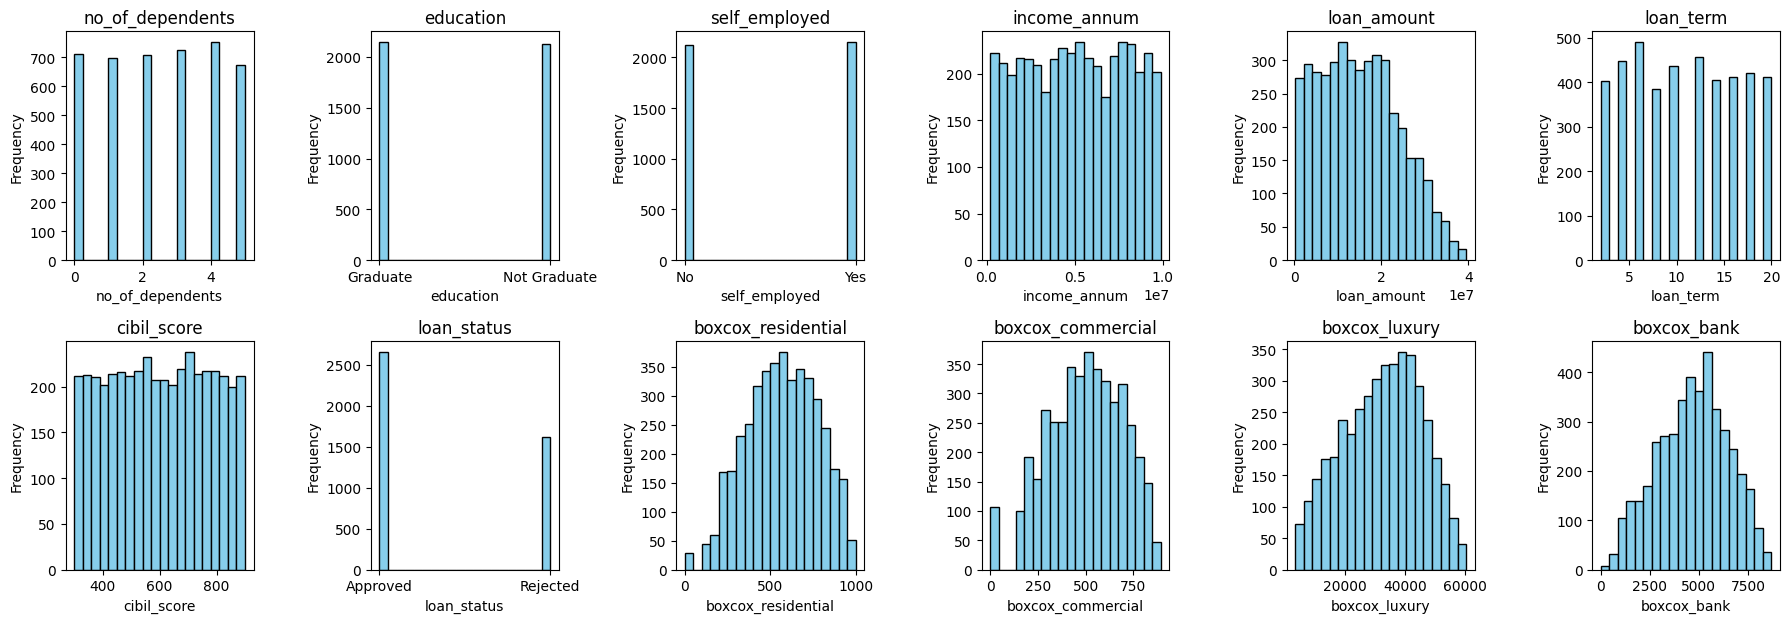

In [11]:
# 연속형 변수가 정규분포의 모양을 보임. 따라서 boxcox 기반의 데이터로 전처리

num_columns = len(df_boxcox.columns)
num_rows = num_columns // 6 + 1

plt.figure(figsize=(18, num_rows * 3))

# 각 변수에 대한 히스토그램
for i, var in enumerate(df_boxcox.columns):
    plt.subplot(num_rows, 6, i + 1)  # 서브플롯의 위치를 조정합니다.
    plt.hist(df_boxcox[var], bins=20, color='skyblue', edgecolor='black')  # 여기서 ss를 사용합니다.
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
temp_df = df_boxcox.copy()

In [13]:
#범주형 변수 바이너리 인코딩
df_boxcox['education'] = df_boxcox['education'].map({'Graduate': 1, 'Not Graduate': 0})
df_boxcox['self_employed'] = df_boxcox['self_employed'].map({'Yes': 1, 'No': 0})
df_boxcox['loan_status'] = df_boxcox['loan_status'].map({'Approved': 1, 'Rejected': 0})

#바이너리 인코딩 한 변수들 따로 저장
# df_boxcox = temp_df[['education', 'self_employed', 'loan_status']]

In [14]:
# 데이터 나누기

X = df_boxcox.drop(['loan_status'], axis =1)
y = df_boxcox['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3415, 11) (3415,) (854, 11) (854,)


In [15]:
# 임시로 데이터의 개수를 확인하기 위한 concat

temp_train_df = pd.concat([X_train, y_train], axis=1)
temp_test_df = pd.concat([X_test, y_test], axis=1)

# 분석에 초점을 맞춘 데이터들이 어느 정도 골고루 분포

print("train in number: ", len(temp_train_df.loc[(temp_train_df['cibil_score'] < 550) & (temp_train_df['loan_status'] == 1)].sort_values(['cibil_score'], ascending= False)))
print("test in number: ", len(temp_test_df.loc[(temp_test_df['cibil_score'] < 550) & (temp_test_df['loan_status'] == 1)].sort_values(['cibil_score'], ascending= False)))

train in number:  149
test in number:  36


In [16]:
# 실제로 초점을 맞춰야 하는 데이터

concen_df = temp_test_df.loc[(temp_test_df['cibil_score'] < 550) & (temp_test_df['loan_status'] == 1)].sort_values(['cibil_score'], ascending= False)
concen_X_test = concen_df.drop(['loan_status'], axis =1)
concen_y_test = concen_df['loan_status']

print(concen_X_test.shape, concen_y_test.shape)

(36, 11) (36,)


In [17]:
concen_df.index

Int64Index([1557, 1344, 3839,  315,  810, 3906, 3127,  321, 3490, 4155, 1237,
            1948,  869, 2873, 1024, 3521, 3624, 1812, 2405, 1566,  564, 1784,
            1047,  915, 4161, 1130, 3458, 2678, 2623, 1803, 1235, 1288, 1456,
            2920, 1717,   95],
           dtype='int64')

In [18]:
ss = StandardScaler()

X_train.iloc[:, :] = ss.fit_transform(X_train)
X_test.iloc[:, :] = ss.transform(X_test)

# X_test 내부에서 신용도가 낮음에도 불구하고 대출 승인된 경우
concen_X_test = X_test.reindex(concen_df.index)

## Gaussian Navie Basian 

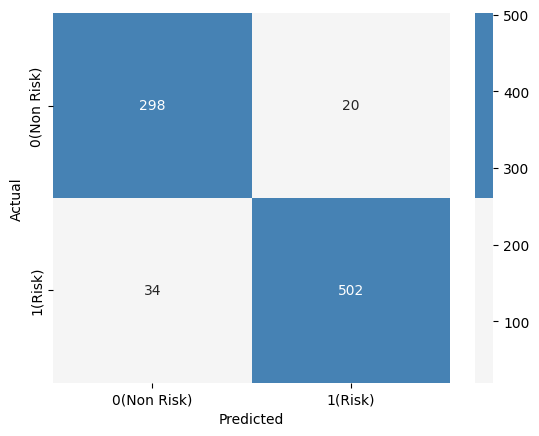

Accuracy: 0.936768149882904
Recall: 0.9365671641791045
Precision: 0.9616858237547893
F1: 0.9489603024574669


In [19]:
# 튜닝 이전의 모델링

nav = GaussianNB()
nav.fit(X_train, y_train)
preds = nav.predict(X_test)

conf_matrix(y_test, preds)

In [20]:
# 튜닝 이전 concen 정확도

preds = nav.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.05555555555555555


In [21]:
# Optuna를 사용하여 nav 최적의 파라미터 찾기

optuna.logging.set_verbosity(optuna.logging.WARNING) # log 안보기
study = optuna.create_study(direction='maximize')
study.optimize(nav_objective, n_trials=100)

# 최적의 파라미터 출력
print("Best trial: ", study.best_trial.params)

Best trial:  {'var_smoothing': 5.389538521100702e-12}


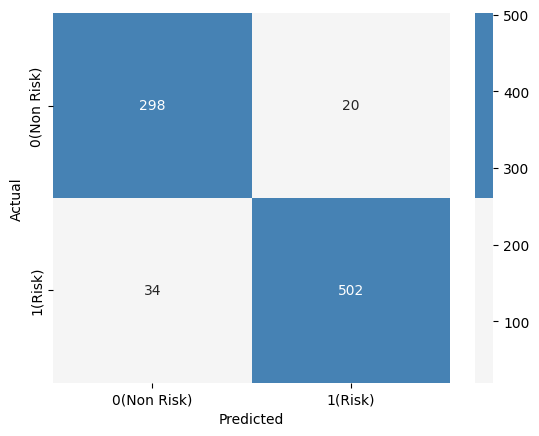

Accuracy: 0.936768149882904
Recall: 0.9365671641791045
Precision: 0.9616858237547893
F1: 0.9489603024574669


In [22]:
nav = GaussianNB(**study.best_trial.params)
nav.fit(X_train, y_train)

preds = nav.predict(X_test)

conf_matrix(y_test, preds)

In [23]:
# GaussianNavieBasian concen data 정확도 

preds = nav.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.05555555555555555


## Logisic Regression

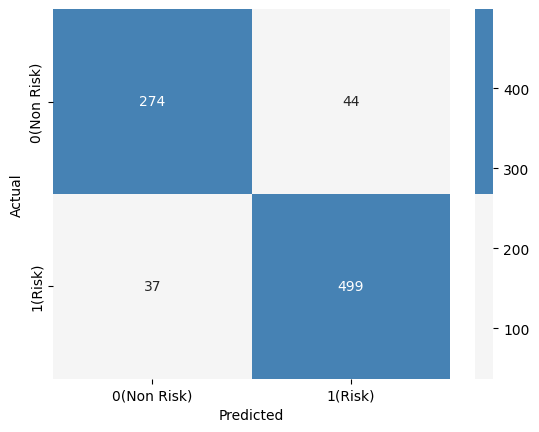

Accuracy: 0.905152224824356
Recall: 0.9309701492537313
Precision: 0.9189686924493554
F1: 0.9249304911955515


In [24]:
# 튜닝 이전의 모델링

lg = LogisticRegression(random_state=21)  
lg.fit(X_train, y_train)

preds = lg.predict(X_test)

conf_matrix(y_test, preds)

In [25]:
# 튜닝 이전 concen 정확도 

preds = lg.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.3611111111111111


In [26]:
# Optuna를 사용하여 lg 최적의 파라미터 찾기

study = optuna.create_study(direction='maximize')
study.optimize(lg_objective, n_trials=100)

# 최적의 파라미터 출력
print("Best trial: ", study.best_trial.params)

Best trial:  {'penalty': 'l2', 'C': 0.01658889193711152, 'tol': 0.0005144522074304822, 'fit_intercept': True, 'solver': 'liblinear', 'max_iter': 511}


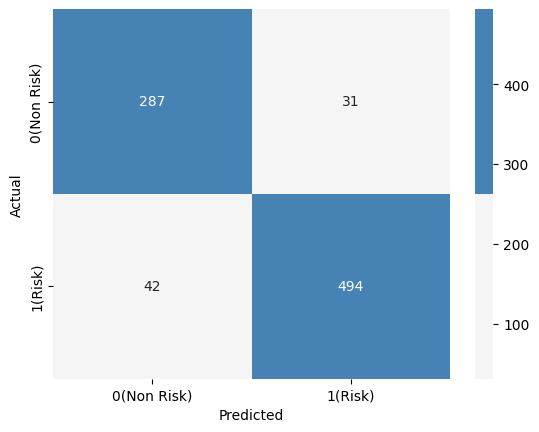

Accuracy: 0.914519906323185
Recall: 0.9216417910447762
Precision: 0.940952380952381
F1: 0.9311969839773799


In [27]:
lg = LogisticRegression(**study.best_trial.params ,random_state=21)  
lg.fit(X_train, y_train)

preds = lg.predict(X_test)

conf_matrix(y_test, preds)

In [28]:
# Logistic concen data 정확도 

preds = lg.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.19444444444444445


## SVM

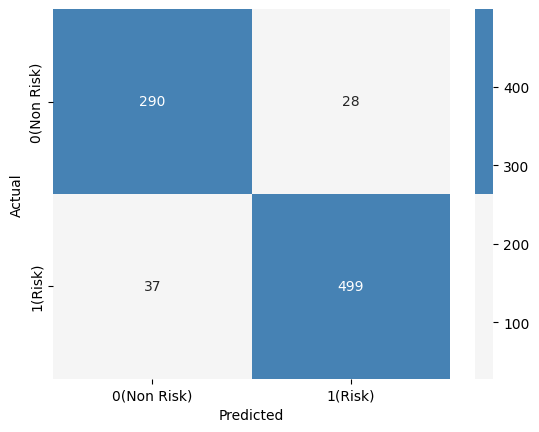

Accuracy: 0.9238875878220141
Recall: 0.9309701492537313
Precision: 0.9468690702087287
F1: 0.9388523047977423


In [29]:
# 튜닝 이전의 모델링

svm = svm.SVC(random_state=42)

svm.fit(X_train, y_train)

preds = svm.predict(X_test)
conf_matrix(y_test, preds)

In [30]:
# 튜닝 이전 concen data

preds = svm.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.4166666666666667


In [35]:
# Optuna를 사용하여 svm 최적의 파라미터 찾기 
# 오류 발생 시 하이퍼 파라미터 튜닝 관련 함수 다시 한번 실행 하기

study = optuna.create_study(direction='maximize')
study.optimize(svm_objective, n_trials=100)

# 최적의 파라미터 출력
print("Best trial: ", study.best_trial.params)

Best trial:  {'C': 4.639628166700745, 'gamma': 'scale', 'kernel': 'rbf', 'coef0': -0.7831958214522137, 'shrinking': True}


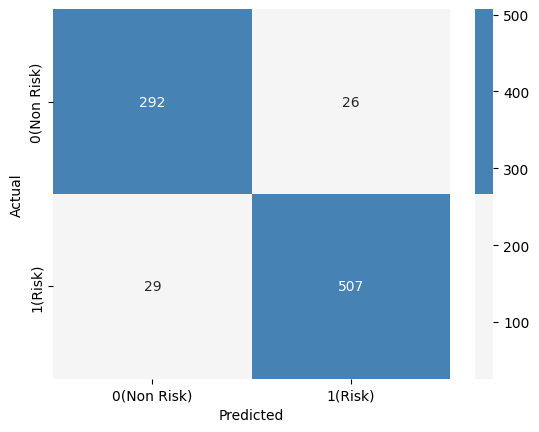

Accuracy: 0.9355971896955504
Recall: 0.9458955223880597
Precision: 0.9512195121951219
F1: 0.9485500467726848


In [36]:
# 
svm = svm.SVC(**study.best_trial.params, random_state=42 , probability=True)

svm.fit(X_train, y_train)

preds = svm.predict(X_test)
conf_matrix(y_test, preds)

In [37]:
# svm concen data 정확도 
# 하이퍼 파라미터 튜닝 후에 성능이 많이 개선이 됨.

preds = svm.predict(concen_X_test)

acc = accuracy_score(concen_y_test, preds)
print("정확도: ", acc)

정확도:  0.6666666666666666


PermutationExplainer explainer: 855it [01:33,  8.08it/s]                         


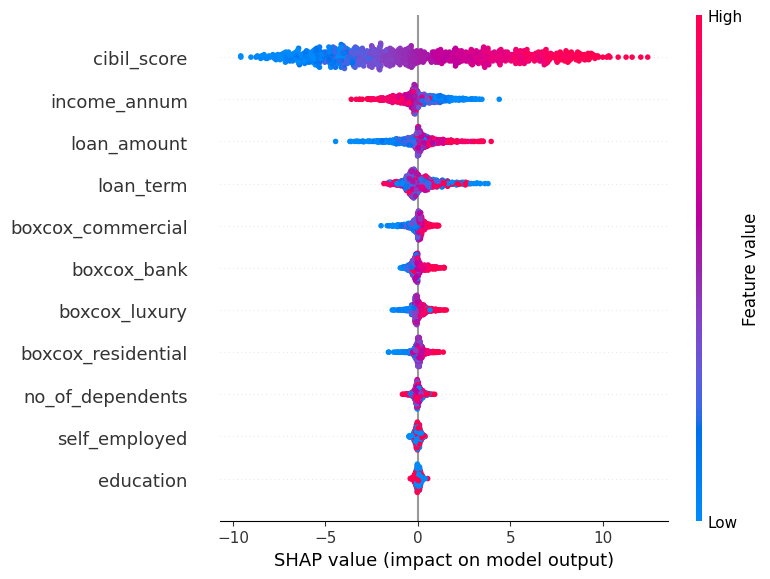

In [44]:
# KernelExplainer 는 시간이 오래걸리는 이유로 Global importance를 보는데는 Explainer를 사용

explainer = shap.Explainer(svm.decision_function, shap.sample(X_train, 100))  # 100개의 샘플로 백그라운드 데이터 샘플링
shap_values = explainer.shap_values(X_test)

# 클래스 별 SHAP 요약 플롯
shap.summary_plot(shap_values, X_test)

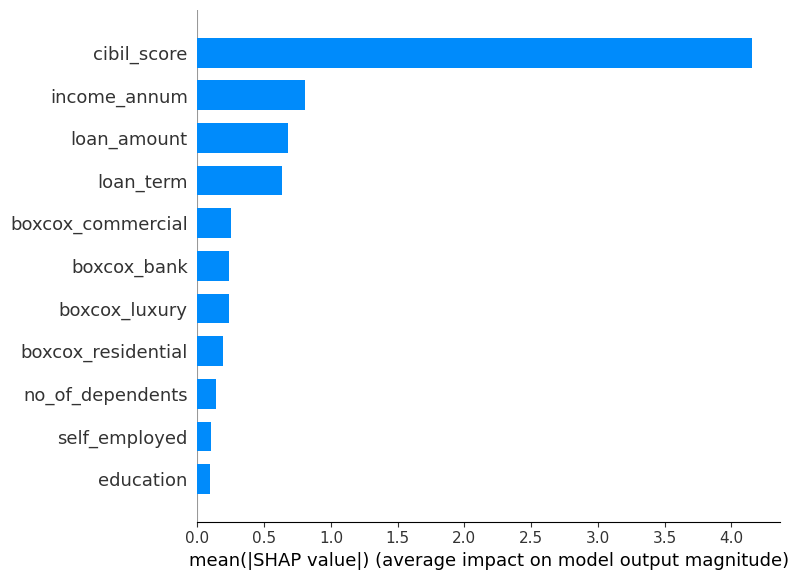

In [37]:
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.show()

In [59]:
# concen data에 대한 force_plot 그려보기 

shap.initjs()
concen_explainer = shap.KernelExplainer(svm.decision_function, shap.sample(X_train, 100))
explanation = concen_explainer(concen_X_test)
shap.plots.force(explanation[0])

  0%|          | 0/36 [00:00<?, ?it/s]